# Data processing

In [2]:
import csv 
import io
import pyspark
import pandas as pd
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import ast
from pyspark.sql.types import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

In [ ]:
#conf = pyspark.SparkConf().setMaster("local").setAppName("My App")
#sc = pyspark.SparkContext(conf = conf)
#sqlContext = SQLContext(sc)
#spark = SparkSession.builder.getOrCreate()

In [3]:
spark = SparkSession.builder \
.master('local[*]') \
.config("spark.driver.memory", "15g") \
.appName('My App') \
.getOrCreate()

Load units

In [4]:
df=pd.read_csv('data_full_encoded_units.csv', index_col=0).reset_index()

/usr/lib/python3/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df_schema = StructType([StructField("index", StringType(), True),
                        StructField("levels", IntegerType(), True),
                        StructField("units_lst", StringType(), True)])

dfs = spark.createDataFrame(df, schema=df_schema)

In [6]:
dfs.printSchema()

root
 |-- index: string (nullable = true)
 |-- levels: integer (nullable = true)
 |-- units_lst: string (nullable = true)



In [7]:
dfs.show(10)

+-----+------+---------+
|index|levels|units_lst|
+-----+------+---------+
|    0|     2|  Nidalee|
|    0|     2|    Teemo|
|    0|     2|   Irelia|
|    0|     2|    Yuumi|
|    0|     2|     Jinx|
|    0|     2| Katarina|
|    0|     2|  Sejuani|
|    0|     2|     Shen|
|    0|     2|     Azir|
|    1|     2|    Elise|
+-----+------+---------+
only showing top 10 rows



In [8]:
df_pivot=dfs.groupBy("index").pivot("units_lst").sum("levels")

In [9]:
df_pivot.printSchema()

root
 |-- index: string (nullable = true)
 |-- Aatrox: long (nullable = true)
 |-- Ahri: long (nullable = true)
 |-- Akali: long (nullable = true)
 |-- Annie: long (nullable = true)
 |-- Aphelios: long (nullable = true)
 |-- Ashe: long (nullable = true)
 |-- Azir: long (nullable = true)
 |-- Cassiopeia: long (nullable = true)
 |-- Diana: long (nullable = true)
 |-- Elise: long (nullable = true)
 |-- Evelynn: long (nullable = true)
 |-- Ezreal: long (nullable = true)
 |-- Fiora: long (nullable = true)
 |-- Garen: long (nullable = true)
 |-- Hecarim: long (nullable = true)
 |-- Irelia: long (nullable = true)
 |-- Janna: long (nullable = true)
 |-- JarvanIV: long (nullable = true)
 |-- Jax: long (nullable = true)
 |-- Jhin: long (nullable = true)
 |-- Jinx: long (nullable = true)
 |-- Kalista: long (nullable = true)
 |-- Katarina: long (nullable = true)
 |-- Kayn: long (nullable = true)
 |-- Kennen: long (nullable = true)
 |-- Kindred: long (nullable = true)
 |-- LeeSin: long (nullable = 

Load traits

In [10]:
df=pd.read_csv('data_full_encoded_traits.csv', index_col=0).reset_index()

df_schema = StructType([StructField("index", StringType(), True),
                        StructField("traits_level", IntegerType(), True),
                        StructField("traits_lst", StringType(), True)])

dfs = spark.createDataFrame(df, schema=df_schema)

df_pivot2=dfs.groupBy("index").pivot("traits_lst").sum("traits_level")

df_pivot2.printSchema()

root
 |-- index: string (nullable = true)
 |-- Adept: long (nullable = true)
 |-- Assassin: long (nullable = true)
 |-- Boss: long (nullable = true)
 |-- Brawler: long (nullable = true)
 |-- Cultist: long (nullable = true)
 |-- Dazzler: long (nullable = true)
 |-- Divine: long (nullable = true)
 |-- Duelist: long (nullable = true)
 |-- Dusk: long (nullable = true)
 |-- Elderwood: long (nullable = true)
 |-- Emperor: long (nullable = true)
 |-- Enlightened: long (nullable = true)
 |-- Exile: long (nullable = true)
 |-- Fortune: long (nullable = true)
 |-- Hunter: long (nullable = true)
 |-- Keeper: long (nullable = true)
 |-- Mage: long (nullable = true)
 |-- Moonlight: long (nullable = true)
 |-- Mystic: long (nullable = true)
 |-- NaN: long (nullable = true)
 |-- Ninja: long (nullable = true)
 |-- Shade: long (nullable = true)
 |-- Sharpshooter: long (nullable = true)
 |-- Spirit: long (nullable = true)
 |-- Tormented: long (nullable = true)
 |-- Vanguard: long (nullable = true)
 |-- 

Load data

In [11]:
data=pd.read_csv('data_modificato.csv', index_col=0).reset_index()

In [12]:
df_schema = StructType([StructField("index", StringType(), True),
                        StructField("patch_version", StringType(), True),
                        StructField("match_id", StringType(), True),
                        StructField("puuid", StringType(), True),
                        StructField("placement", IntegerType(), True),
                        StructField("level", IntegerType(), True),
                        StructField("gold_left", IntegerType(), True),
                        StructField("last_round", IntegerType(), True),
                        StructField("time_in_game", FloatType(), True),
                        StructField("total_dmg_to_players", IntegerType(), True),
                        StructField("players_eliminated", IntegerType(), True),
                        StructField("chosen_unit", StringType(), True),
                        StructField("chosen_trait", StringType(), True),
                        StructField("units", StringType(), True),
                        StructField("traits", StringType(), True),
                        StructField("units_lst", StringType(), True),
                        StructField("levels", StringType(), True),
                        StructField("traits_lst", StringType(), True),
                        StructField("traits_level", StringType(), True)])

data_spark = spark.createDataFrame(data, schema=df_schema)

In [13]:
data_spark=data_spark.drop('units', 'traits', 'units_lst', 'levels', 'traits_lst', 'traits_level')

Merge datasets

In [14]:
data_final=data_spark.join(df_pivot, on='index')
data_final=data_final.join(df_pivot2, on='index')

In [15]:
data_final.printSchema()

root
 |-- index: string (nullable = true)
 |-- patch_version: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- puuid: string (nullable = true)
 |-- placement: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- gold_left: integer (nullable = true)
 |-- last_round: integer (nullable = true)
 |-- time_in_game: float (nullable = true)
 |-- total_dmg_to_players: integer (nullable = true)
 |-- players_eliminated: integer (nullable = true)
 |-- chosen_unit: string (nullable = true)
 |-- chosen_trait: string (nullable = true)
 |-- Aatrox: long (nullable = true)
 |-- Ahri: long (nullable = true)
 |-- Akali: long (nullable = true)
 |-- Annie: long (nullable = true)
 |-- Aphelios: long (nullable = true)
 |-- Ashe: long (nullable = true)
 |-- Azir: long (nullable = true)
 |-- Cassiopeia: long (nullable = true)
 |-- Diana: long (nullable = true)
 |-- Elise: long (nullable = true)
 |-- Evelynn: long (nullable = true)
 |-- Ezreal: long (nullable = true)
 |-- Fio

In [16]:
data_final = data_final.filter((data_final.patch_version != '11.10') & (data_final.patch_version != '10.19'))

## Plots

In [17]:
import matplotlib.pyplot as plt

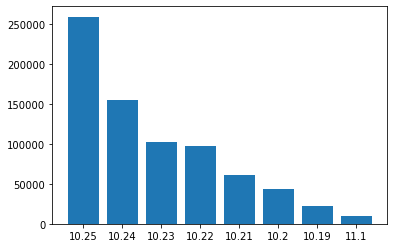

In [55]:
patch=data.patch_version.value_counts().reset_index()
plt.bar(patch['index'].apply(str), patch.patch_version)
plt.show()

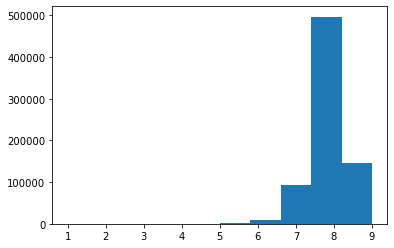

In [56]:
plt.hist(data.level)
plt.show()

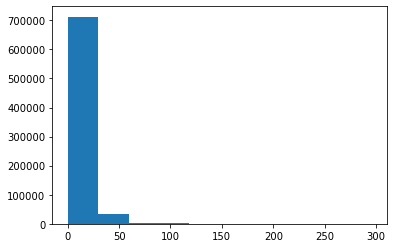

In [57]:
plt.hist(data.gold_left)
plt.show()

[]

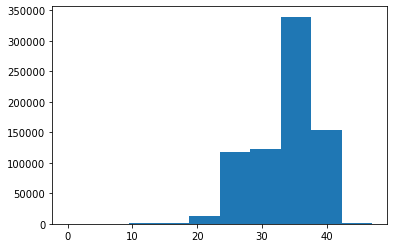

In [58]:
plt.hist(data.last_round)
plt.plot()

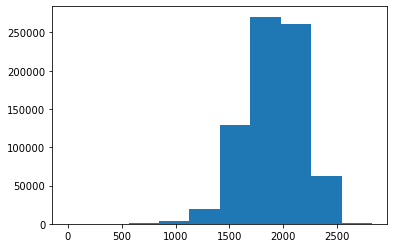

In [59]:
plt.hist(data.time_in_game)
plt.show()

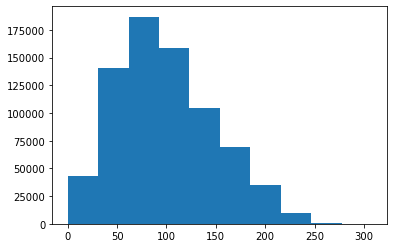

In [60]:
plt.hist(data.total_dmg_to_players)
plt.show()

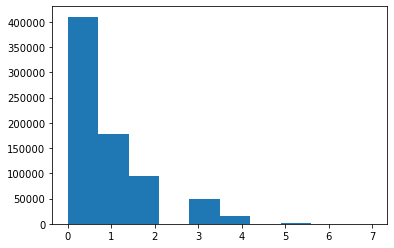

In [61]:
plt.hist(data.players_eliminated)
plt.show()

In [1]:
data.corr()

NameError: name 'data' is not defined

## Clustering

In [18]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession

In [19]:
data_final=data_final.drop('NaN')

In [20]:
data_final.printSchema()

root
 |-- index: string (nullable = true)
 |-- patch_version: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- puuid: string (nullable = true)
 |-- placement: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- gold_left: integer (nullable = true)
 |-- last_round: integer (nullable = true)
 |-- time_in_game: float (nullable = true)
 |-- total_dmg_to_players: integer (nullable = true)
 |-- players_eliminated: integer (nullable = true)
 |-- chosen_unit: string (nullable = true)
 |-- chosen_trait: string (nullable = true)
 |-- Aatrox: long (nullable = true)
 |-- Ahri: long (nullable = true)
 |-- Akali: long (nullable = true)
 |-- Annie: long (nullable = true)
 |-- Aphelios: long (nullable = true)
 |-- Ashe: long (nullable = true)
 |-- Azir: long (nullable = true)
 |-- Cassiopeia: long (nullable = true)
 |-- Diana: long (nullable = true)
 |-- Elise: long (nullable = true)
 |-- Evelynn: long (nullable = true)
 |-- Ezreal: long (nullable = true)
 |-- Fio

In [21]:
data_final_clean = data_final.fillna(float(0))

In [22]:
data_final_clean = data_final_clean.na.fill(value=0)

In [23]:
data_class = data_final_clean.drop('patch_version', 'match_id', 'puuid','chosen_unit','chosen_trait','placement','level','gold_left', 'last_round', 'time_in_game', 'total_dmg_to_players', 'players_eliminated')

In [ ]:
#from pyspark.ml.classification import RandomForestClassifier
#from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
#from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#from pyspark.sql import SparkSession

In [24]:
# Non termina, la quantità di colonne dopo il pivot potrebbe essere il problema (si dovrebbe eliminare il numero a destra corrispondente all'item
# posseduto dal personaggio per evitare che un giocatore abbia vayne_1 vayne_14, ecc..)

cols_in = [col for col in data_class.columns if col != 'index']

assembler = VectorAssembler(inputCols=cols_in, outputCol="features", handleInvalid="skip")

output_data_class = assembler.transform(data_class).select('index', 'features')

In [25]:
output_data_class.show(3)

+------+--------------------+
| index|            features|
+------+--------------------+
|100010|(84,[2,8,22,28,36...|
|100140|(84,[7,19,20,37,3...|
|100227|(84,[0,1,3,7,38,4...|
+------+--------------------+
only showing top 3 rows



In [33]:
size =[]
cost=[]
for i in range(2,15):
    model= KMeans(k=i)
    model.setMaxIter(10)
    #model.setDistanceMeasure('cosine')
    out = model.fit(output_data_class)
    summary = out.summary
    size.append(summary.clusterSizes)
    cost.append(summary.trainingCost)
    

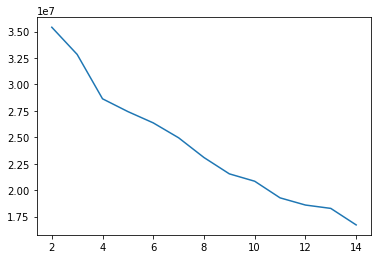

In [36]:
plt.plot(range(2,15), cost)

In [25]:
model= KMeans(k=9)
model.setMaxIter(10)
#model.setDistanceMeasure('cosine')
out = model.fit(output_data_class)

In [26]:
predictions = out.transform(output_data_class)

In [ ]:
predictions.show()

In [27]:
data_final=data_final.join(predictions, on='index')

In [ ]:
data_final.count()

In [30]:
centroid = out.clusterCenters()
for c in centroid:
    for i in range(len(cols_in)):
        if [x > 0.6 for x in c][i] == True:
    
            
            print(cols_in[i])
    print("_______")
    

Aatrox
Azir
Cassiopeia
Jhin
Lillia
Riven
Thresh
Vayne
Zilean
Cultist
Dusk
Keeper
Mystic
Sharpshooter
Vanguard
Warlord
_______
Akali
Aphelios
Diana
Irelia
Kindred
Lissandra
Lux
Pyke
Sylas
Yuumi
Adept
Assassin
Brawler
Cultist
Dazzler
Divine
Enlightened
Hunter
Moonlight
Mystic
Ninja
Spirit
_______
Jhin
Jinx
Nidalee
Sejuani
Teemo
Thresh
Vayne
Cultist
Dusk
Fortune
Keeper
Mystic
Sharpshooter
Spirit
Vanguard
Warlord
_______
Irelia
Janna
Jax
Lux
Morgana
Shen
Warwick
Yone
Adept
Brawler
Cultist
Dazzler
Divine
Duelist
Elderwood
Enlightened
Exile
Hunter
Mystic
Ninja
_______
Aatrox
Ahri
Annie
Cassiopeia
Lulu
Sejuani
Shen
Thresh
Yuumi
Adept
Cultist
Dusk
Elderwood
Enlightened
Fortune
Mage
Mystic
Spirit
Vanguard
_______
Ashe
Ezreal
Hecarim
Kindred
Lulu
Maokai
Nunu
Sett
Veigar
Warwick
Brawler
Dazzler
Divine
Elderwood
Hunter
Mage
_______
Akali
Evelynn
Kennen
Pyke
Shen
Zed
Adept
Assassin
Cultist
Keeper
Mystic
Ninja
Shade
_______
Aatrox
Elise
Evelynn
Jhin
Kalista
Pyke
TwistedFate
Zilean
Assassin
Cultist
D

In [41]:
summary = out.summary
print(summary.k)
print(summary.clusterSizes)
print(summary.trainingCost)

9
[22274, 48343, 29604, 82027, 192068, 48168, 229594, 33450, 40704]
21538446.2345162


In [43]:
data_final.groupBy('prediction').min('placement').show()

+----------+--------------+
|prediction|min(placement)|
+----------+--------------+
|         1|             1|
|         6|             1|
|         3|             1|
|         5|             1|
|         4|             1|
|         8|             1|
|         7|             1|
|         2|             1|
|         0|             1|
+----------+--------------+



In [42]:
data_final.groupBy('prediction').avg('placement').show()

+----------+------------------+
|prediction|    avg(placement)|
+----------+------------------+
|         1| 4.614732225968599|
|         6| 4.542675331236879|
|         3| 4.618649956721567|
|         5| 4.478595748214582|
|         4|  4.38888831039007|
|         8|4.4847926493710695|
|         7| 4.548729446935725|
|         2| 4.375658694770977|
|         0| 4.498428661219359|
+----------+------------------+



In [44]:
data_final.groupBy('prediction').max('placement').show()

+----------+--------------+
|prediction|max(placement)|
+----------+--------------+
|         1|             8|
|         6|             8|
|         3|             8|
|         5|             8|
|         4|             8|
|         8|             8|
|         7|             8|
|         2|             8|
|         0|             8|
+----------+--------------+



In [45]:
import pyspark.sql.functions as func    

data_final.groupBy("prediction").agg(func.percentile_approx("placement", 0.5).alias("median")).show()


+----------+------+
|prediction|median|
+----------+------+
|         1|     5|
|         6|     5|
|         3|     5|
|         5|     4|
|         4|     4|
|         8|     4|
|         7|     5|
|         2|     4|
|         0|     5|
+----------+------+



In [31]:
model= KMeans(k=4)
model.setMaxIter(10)
#model.setDistanceMeasure('cosine')
out = model.fit(output_data_class)

In [32]:
predictions4 = out.transform(output_data_class)
#data_final=data_final.join(predictions4, on='index')

centroid = out.clusterCenters()
for c in centroid:
    for i in range(len(cols_in)):
        if [x > 0.6 for x in c][i] == True:
    
            
            print(cols_in[i])
    print("_______")

Ashe
Irelia
Jax
Kindred
Lux
Shen
Warwick
Yone
Adept
Brawler
Dazzler
Divine
Duelist
Elderwood
Enlightened
Exile
Hunter
Mystic
Ninja
Spirit
_______
Aatrox
Azir
Cassiopeia
Jhin
Riven
Sejuani
Thresh
Vayne
Cultist
Dusk
Fortune
Keeper
Mage
Mystic
Sharpshooter
Vanguard
Warlord
_______
Akali
Diana
Irelia
Janna
Lux
Morgana
Pyke
Shen
Talon
Zed
Adept
Assassin
Cultist
Dazzler
Divine
Enlightened
Keeper
Moonlight
Mystic
Ninja
Shade
_______
Annie
Ashe
Hecarim
Lulu
Maokai
Nunu
Veigar
Warwick
Brawler
Divine
Elderwood
Hunter
Mage
Spirit
_______


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 59962)
Traceback (most recent call last):
  File "/usr/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/hpsa13/.local/lib/python3.8/site-packages/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/home/hpsa13/.local/lib/python3.8/site-packages/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/home/hpsa13/.local/lib/python3.8/site-packages/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(

In [72]:
summary = out.summary
print(summary.k)
print(summary.clusterSizes)
print(summary.trainingCost)

4
[282699, 283012, 51069, 109452]
28638226.772627972


In [73]:
data_final.groupBy('prediction').min('placement').show()

+----------+--------------+
|prediction|min(placement)|
+----------+--------------+
|         1|             1|
|         3|             1|
|         2|             1|
|         0|             1|
+----------+--------------+



In [74]:
data_final.groupBy('prediction').avg('placement').show()

+----------+-----------------+
|prediction|   avg(placement)|
+----------+-----------------+
|         1|4.525408816587283|
|         3| 4.59469904615722|
|         2|4.637607942195853|
|         0|4.413040017828149|
+----------+-----------------+



In [75]:
data_final.groupBy('prediction').max('placement').show()

+----------+--------------+
|prediction|max(placement)|
+----------+--------------+
|         1|             8|
|         3|             8|
|         2|             8|
|         0|             8|
+----------+--------------+



In [76]:
import pyspark.sql.functions as func    

data_final.groupBy("prediction").agg(func.percentile_approx("placement", 0.5).alias("median")).show()

+----------+------+
|prediction|median|
+----------+------+
|         1|     5|
|         3|     5|
|         2|     5|
|         0|     4|
+----------+------+

